Loading and preprocessing data...
Data shapes:
Training data: (440833, 11)
Testing data: (64374, 11)

Class distribution in training set:
Churn
1.0    0.567108
0.0    0.432892
Name: proportion, dtype: float64

Training XGBoost model with best parameters...

Model Performance Metrics:
Threshold: 0.350
Balanced Accuracy: 0.552
ROC AUC: 0.761
F1 Score: 0.667
Precision: 0.501
Recall: 0.997

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.11      0.19     33881
           1       0.50      1.00      0.67     30493

    accuracy                           0.53     64374
   macro avg       0.74      0.55      0.43     64374
weighted avg       0.75      0.53      0.42     64374



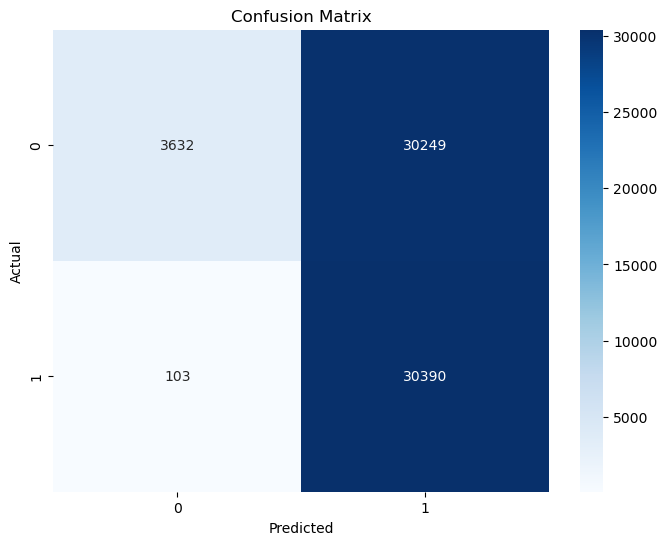

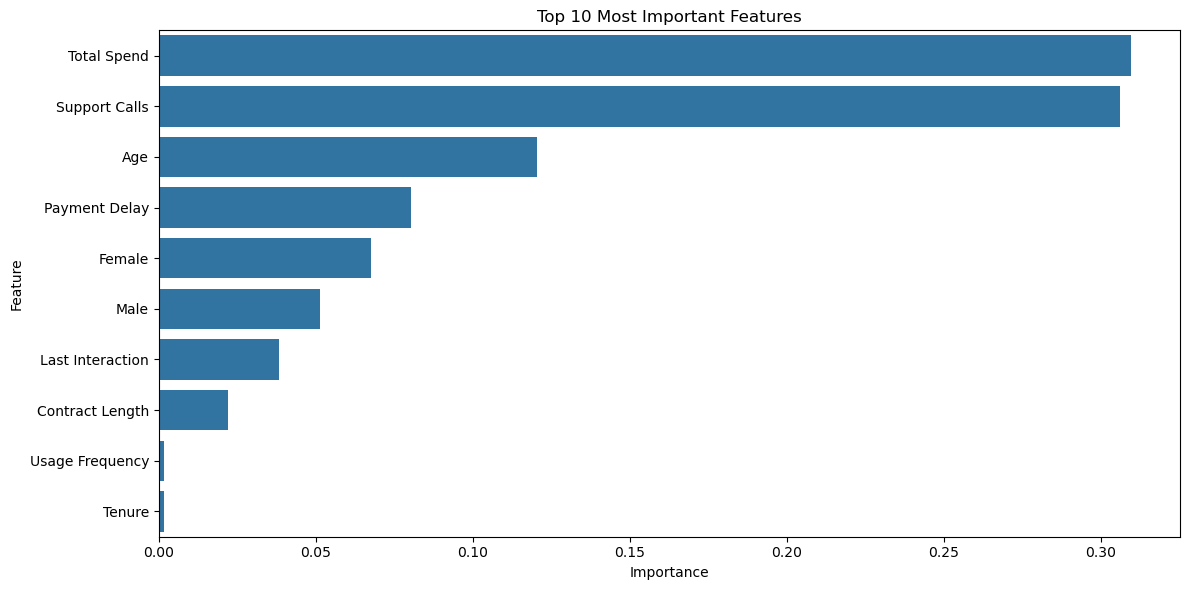


Top 5 Most Important Features:
      Feature  Importance
  Total Spend    0.309831
Support Calls    0.306135
          Age    0.120517
Payment Delay    0.080504
       Female    0.067746


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, balanced_accuracy_score,
                           confusion_matrix, classification_report)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

def load_and_preprocess():
    print("Loading and preprocessing data...")
    
    # Load training and testing datasets
    train_data = pd.read_csv('../Dataset/cleaned_customer_churn_dataset_training.csv')
    test_data = pd.read_csv('../Dataset/cleaned_customer_churn_dataset_testing.csv')
    
    # Separate features and target
    X_train = train_data.drop(['CustomerID', 'Churn'], axis=1)
    y_train = train_data['Churn']
    X_test = test_data.drop(['CustomerID', 'Churn'], axis=1)
    y_test = test_data['Churn']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Data shapes:")
    print(f"Training data: {X_train_scaled.shape}")
    print(f"Testing data: {X_test_scaled.shape}")
    print("\nClass distribution in training set:")
    print(pd.Series(y_train).value_counts(normalize=True))
    
    return X_train_scaled, X_test_scaled, y_train, y_test, X_train.columns

def train_xgboost(X_train, y_train):
    """Train XGBoost model with best parameters"""
    print("\nTraining XGBoost model with best parameters...")
    
    # Initialize model with best parameters
    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=5,
        min_child_weight=3,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        verbosity=0
    )
    
    # Train the model
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, feature_names):
    """Evaluate the model and display results"""
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Use the optimal threshold found (0.350)
    threshold = 0.350
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print(f"Threshold: {threshold:.3f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Feature importance plot
    plt.figure(figsize=(12, 6))
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(data=importance.head(10), x='Importance', y='Feature')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    # Print top 5 features
    print("\nTop 5 Most Important Features:")
    print(importance.head().to_string(index=False))

def main():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess()
    
    # Train model with best parameters
    model = train_xgboost(X_train, y_train)
    
    # Evaluate model
    evaluate_model(model, X_test, y_test, feature_names)

if __name__ == "__main__":
    main()